# Recommendation by Character images: Preprocessing

#### ToDo

- [x] Preparations
    - [x] data retrieval
    - [x] convert images to black and white
    - [x] set transformations (`ToTensor()`, `RandomCrop()`)
    - [x] create Dataset
    - [x] create Dataloader
- [x] Representation learning: try with few images
    - [x] define encoder
    - [x] define decoder
    - [x] training codes 
    - [x] training loss visualization
    - [x] validation codes
    - [x] wrap training and validation codes into class
    - [x] create embedding
    - [x] try saving the best encoder model, decoder model, and embedding into files
- [x] Similarity calculation
    - [x] build most basic similarity search -> query character and it pulls out similar characters
    - [x] convert character-based representation to title-based representation (sum for each title? average?)
- [x] Recommendation
    - [x] recommender function (similarity calculation results = recommendation)
- [x] Full data learning ~ recommendation
    - [x] train with larger data
    - [x] create and save representation data

#### Other ToDo
- [x] Trouble shooting
    - [x] Fixing "Training loss not going down" problem
        - Problem: Training loss goes down sometimes, but sometimes it doesn't go down from ~0.4
        - [x] preprocessing -> Changed from RandomCrop -> CenterCrop, Normalize
        - [x] Training loss at ~0.4 and not going down -> Model layer -> last layer to be Sigmoid and NOT ReLU for both
        - CenterCrop could really be the reason. After all the improvements, I put back the RandomCrop, and the "training loss not going down" problem happened again
    - [x] Fixing "not seeing the drawing style" problem
        - Problem: Similarity calculations are not bad, but doesn't "see" the drawing styles, and it only seems to consider the color/contrast of the images
        - [x] Horizontal flip or Rotation after centercropping the image (----> __v2__)
        - [x] Try different sized filters like VGG or Inception (1x1, 5x5, 7x7)

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import itertools
import copy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# images
# import cv2
from PIL import Image
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

# import image based recommendation module
from ibfilter import ImageBasedRecommendation

---
## Data retrieval
---

In [2]:
# 20p -> 100 titles -> 2111 character images
# 200p -> 6231 titles -> 39939 images

df_charas = pd.read_csv("../assets/characters_200p.csv")
display(df_charas.head())

In [3]:
# Reduce the data down to first 500 titles
first_500_titles = df_charas["title_id"].unique()[:500]
df_charas_reduced = df_charas[df_charas["title_id"].isin(first_500_titles)]
df_charas_reduced = df_charas_reduced.drop_duplicates(subset="character_image_url")

# save
df_charas_reduced.to_csv("../assets/characters_498_titles", index=False)

---
## Image conversion: from RGB to grayscale
---

In [4]:
# get one image
img = Image.open("../assets/character_images/character_images/10138.png").convert("L")
print(img.format, img.size, img.mode)
img.save("../assets/character_images/character_images_grayscale/10138.png")

None (230, 345) L


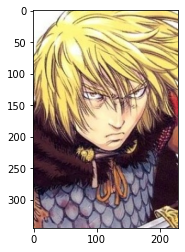

In [5]:
img = Image.open("../assets/character_images/character_images/10138.png")
plt.imshow(np.array(img))

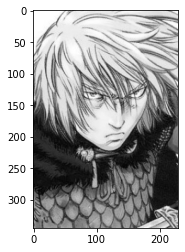

In [6]:
# Confirm grayscale conversion succeeds
img = Image.open("../assets/character_images/character_images_grayscale/10138.png")
plt.imshow(np.array(img), cmap="gray")

In [7]:
# # convert all images to grayscale
# img_list = os.listdir("../assets/character_images/character_images/")
# for img in tqdm(img_list):
#     try:
#         grey_img = Image.open("../assets/character_images/character_images/"+img).convert("L")
#         grey_img.save("../assets/character_images/character_images_grayscale/"+img)
#     except:
#         print("error at: ", img)

In [8]:
# check if all images have been converted
print(len(os.listdir("../assets/character_images/character_images/")))
print(len(os.listdir("../assets/character_images/character_images_grayscale/")))

7798
7798


---
## Check image sizes
---

In [9]:
# Research possible size patterns first
img_list = os.listdir("../assets/character_images/character_images/")
size_patterns = []
for img in img_list:
    try:
        grey_img = np.array(Image.open("../assets/character_images/character_images_grayscale/"+img))
        size_patterns.append(grey_img.shape) # each shape is (h,w)
        # checking the id of small and large images
        if (grey_img.shape[0] < 80) or (grey_img.shape[0] > 450):
            print(img)
        elif (grey_img.shape[1] < 80):
            print(img)
    except:
        pass

262137.png
183076.png
133532.png
131808.png
183075.png
82573.png
8778.png
120852.png


In [10]:
# Find the max size: each tuple is (height, width)
max_height_img = sorted(size_patterns, key=lambda x: x[0], reverse=True)[0]
max_width_img = sorted(size_patterns, key=lambda x: x[1], reverse=True)[0]
print("max height and max width images: ", max_height_img, max_width_img)

# Find the min size
min_height_img = sorted(size_patterns, key=lambda x: x[0], reverse=False)[0]
min_width_img = sorted(size_patterns, key=lambda x: x[1], reverse=False)[0]
print("min height and min width images: ", min_height_img, min_width_img)

# height can vary from 72 to 491
# width can vary from 78 to 230

# examples of small/large images 
# 262137.png # big (450, 230 ish)
# 183076.png
# 133532.png
# 131808.png
# 183075.png
# 82573.png # (72, 140)
# 8778.png # (97, 78)
# 120852.png

# 
display(pd.Series(size_patterns).value_counts())

max height and max width images:  (491, 230) (326, 230)
min height and min width images:  (72, 140) (97, 78)


(345, 230)    3251
(358, 230)    1005
(350, 225)     943
(360, 230)     297
(344, 230)     221
              ... 
(301, 230)       1
(81, 121)        1
(450, 230)       1
(280, 181)       1
(285, 208)       1
Length: 500, dtype: int64

---
## Image transformation
---

shape before transformation:  (487, 230)
shape after transformation:  torch.Size([1, 200, 200])


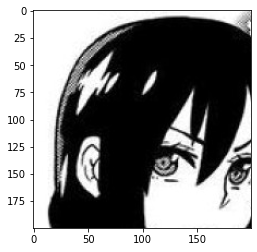

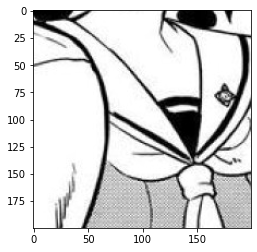

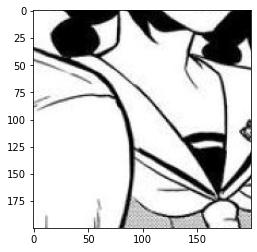

In [11]:
# transform: check cropping process
try_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.RandomCrop(200, pad_if_needed=True)
                                  ])

img = Image.open("../assets/character_images/character_images_grayscale/183076.png")

# check: tensor conversion and addition of channel dimension
img_before = np.array(img)
img_after = try_transform(img)
print("shape before transformation: ", img_before.shape) # [h,w]
print("shape after transformation: ", img_after.size()) # [c,h,w]

# check: if small/large images are cropped ok (padded if img is small)
imgs_after = [try_transform(img) for _ in range(3)]
back_transform = transforms.Compose([transforms.ToPILImage()])
for img in imgs_after:
    pil_img = back_transform(img)
    plt.imshow(np.array(pil_img), cmap="gray")
    plt.show()